<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_RClarke/blob/master/HW9/mltsa_hw9_rclarke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
% matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
plt.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

In [0]:
!pip install kaggle

In [5]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [7]:
ls kaggle.json

kaggle.json


In [0]:
!chmod 600 kaggle.json

In [0]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [10]:
!kaggle competitions list -s PLAsTiCC

ref            deadline             category   reward  teamCount  userHasEntered  
-------------  -------------------  --------  -------  ---------  --------------  
PLAsTiCC-2018  2018-12-17 23:59:00  Featured  $25,000       1094            True  


In [11]:
cd plasticc

/content/gdrive/My Drive/plasticc


In [12]:
cd data

/content/gdrive/My Drive/plasticc/data


In [0]:
#!kaggle competitions download PLAsTiCC-2018

test_set_batch7.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch11.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
training_set.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch5.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
data_note.pdf.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch3.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_set_batch2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
training_set_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
test_set.csv.zip: Skipping, found more re

In [0]:
ls

allfeatures                test_set_batch2.csv.zip  test_set.csv.zip
allfeatures.npy            test_set_batch3.csv.zip  test_set_metadata.csv.zip
data_note.pdf.zip          test_set_batch4.csv.zip  test_set_sample.csv.zip
metadata                   test_set_batch5.csv.zip  training_set.csv
sample_submission.csv.zip  test_set_batch6.csv.zip  training_set.csv.zip
test_set_batch10.csv.zip   test_set_batch7.csv.zip  training_set_metadata.csv
test_set_batch11.csv.zip   test_set_batch8.csv.zip
test_set_batch1.csv.zip    test_set_batch9.csv.zip


In [0]:
!unzip training_set.csv.zip

Archive:  training_set.csv.zip
replace training_set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training_set.csv        


In [0]:
lcvs = pd.read_csv('training_set.csv')
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [0]:
starts = lcvs.groupby(["object_id"])[["mjd"]].min()
starts

,mjd
object_id,
615,59750.4229
713,59825.2600
730,59798.3205
745,59770.3662
1124,59750.4229
...,...
130739978,59790.3778
130755807,59581.3605
130762946,59620.2130


In [0]:
starts['mjd'].loc[starts.index == 615].values[0]

59750.4229

In [0]:
lcvs['object_id'].values[0]

615

Create new domain where each object is time indexed with its first observation being zero

In [0]:
#Very stupid and expensive way to do this:

mjd_new = np.zeros(lcvs.shape[0])

for i, obj in enumerate(lcvs['object_id'].values):

  if lcvs['mjd'][i] == starts['mjd'].loc[starts.index == obj].values[0]:
    pass

  else:
    mjd_new[i] = lcvs['mjd'][i] - starts['mjd'].loc[starts.index == obj]

 
mjd_new

array([0.000000e+00, 7.700000e-03, 1.540000e-02, ..., 8.606095e+02,
       8.755844e+02, 8.776242e+02])

In [0]:
lcvs['mjd_new'] = mjd_new
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected,mjd_new
0,615,59750.4229,2,-544.810303,3.622952,1,0.0000
1,615,59750.4306,1,-816.434326,5.553370,1,0.0077
2,615,59750.4383,3,-471.385529,3.801213,1,0.0154
3,615,59750.4450,4,-388.984985,11.395031,1,0.0221
4,615,59752.4070,2,-681.858887,4.041204,1,1.9841


In [0]:
lcvs.to_pickle('lcvs.pkl')

In [0]:
lcvs = pd.read_pickle('lcvs.pkl')

In [14]:
lcvs_p4 = lcvs.loc[lcvs['passband'].values == 4]
lcvs_p4.head()

,object_id,mjd,passband,flux,flux_err,detected,mjd_new
3,615,59750.4450,4,-388.984985,11.395031,1,0.0221
7,615,59752.4334,4,-393.480225,3.599346,1,2.0105
12,615,59767.3233,4,-405.663818,3.496113,1,16.9004
17,615,59770.2445,4,-400.270386,3.834955,1,19.8216
22,615,59779.3452,4,-422.184509,4.089213,1,28.9223


Find length of shortest time series:

In [18]:
cnts = []

for obj in lcvs_p4['object_id'].unique():
  cnts.append(len(lcvs_p4.loc[lcvs_p4['object_id'].values == obj]))

np.min(cnts)

9

In [19]:
lcvs_p4['object_id'].unique()

array([      615,       713,       730, ..., 130762946, 130772921,
       130779836])

In [20]:
lcvs_p4['mjd_new'].loc[lcvs_p4['object_id'] == 713][0:9].values

array([2.62000e-02, 1.39822e+01, 1.69650e+01, 2.89751e+01, 3.19541e+01,
       4.19262e+01, 4.49182e+01, 4.79104e+01, 5.88954e+01])

In [21]:
lp4_col = np.zeros((7848, 18))

for i, obj in enumerate(lcvs_p4['object_id'].unique()):
  for j in range(0,9):
    np.put(lp4_col[i][:], range(0,9), lcvs_p4['mjd_new'].loc[lcvs_p4['object_id'] == obj][0:9].values)
  for k in range(10,19):
    np.put(lp4_col[i][:], range(9,18), lcvs_p4['flux'].loc[lcvs_p4['object_id'] == obj][0:9].values)

lp4_col

array([[ 2.21000000e-02,  2.01050000e+00,  1.69004000e+01, ...,
         3.60397858e+02, -6.09423330e+01, -3.11977783e+02],
       [ 2.62000000e-02,  1.39822000e+01,  1.69650000e+01, ...,
         2.80503200e+00,  3.11723800e+00,  2.09971100e+00],
       [ 2.61000000e-02,  3.06100000e+00,  2.80162000e+01, ...,
         9.56947000e-01,  2.51195000e-01, -7.39414000e-01],
       ...,
       [ 3.17340000e+00,  4.16920000e+00,  6.16800000e+00, ...,
        -4.04133680e+01, -1.71885190e+01, -4.28879810e+01],
       [ 7.97080000e+00,  1.50129000e+01,  4.39131000e+01, ...,
         3.42011000e+00,  7.43219900e+00, -4.04799900e+00],
       [ 1.18958000e+01,  1.80183000e+01,  5.87269000e+01, ...,
         5.49828750e+04,  3.04264795e+03,  1.99136682e+03]])

In [22]:
lp4_col.shape

(7848, 18)

In [23]:
N = lp4_col.shape[1]
N

18

In [0]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(lp4_col, lp4_col, 
                                             test_size = .25, random_state=1)

In [25]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((5886, 18), (1962, 18), (5886, 18), (1962, 18))

In [0]:
def create_model(bottleneck=128, input_dim=18):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim=input_dim))
  model.add(Dense(128, activation='relu', name="bottleneck"))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(input_dim, activation='relu'))
  #model.add(Dense(input_dim*4, activation='sigmoid'))
  model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")
  return model
model = create_model(input_dim=N)

In [30]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               4864      
_________________________________________________________________
bottleneck (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 18)                4626      
Total params: 75,410
Trainable params: 75,410
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(X_tr, y_tr, epochs=1000, batch_size=16, verbose=1)

Epoch 1/1000
5886/5886 [==============================] - 1s 106us/step - loss: 2132751.9450 - mae: 115.1074 - acc: 0.0433
Epoch 2/1000
5886/5886 [==============================] - 1s 86us/step - loss: 1727986.9647 - mae: 103.8160 - acc: 0.0644
Epoch 3/1000
5886/5886 [==============================] - 1s 86us/step - loss: 1703801.3139 - mae: 100.9550 - acc: 0.0674
Epoch 4/1000
5886/5886 [==============================] - 1s 86us/step - loss: 1779668.5362 - mae: 100.1143 - acc: 0.0759
Epoch 5/1000
5886/5886 [==============================] - 1s 86us/step - loss: 1734087.1027 - mae: 98.4316 - acc: 0.0761
Epoch 6/1000
5886/5886 [==============================] - 0s 85us/step - loss: 1847014.9756 - mae: 97.7077 - acc: 0.0739
Epoch 7/1000
5886/5886 [==============================] - 1s 87us/step - loss: 1753023.1909 - mae: 96.2444 - acc: 0.0838
Epoch 8/1000
5886/5886 [==============================] - 1s 86us/step - loss: 1734580.6663 - mae: 95.0005 - acc: 0.0858
Epoch 9/1000
5886/5886 [===

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


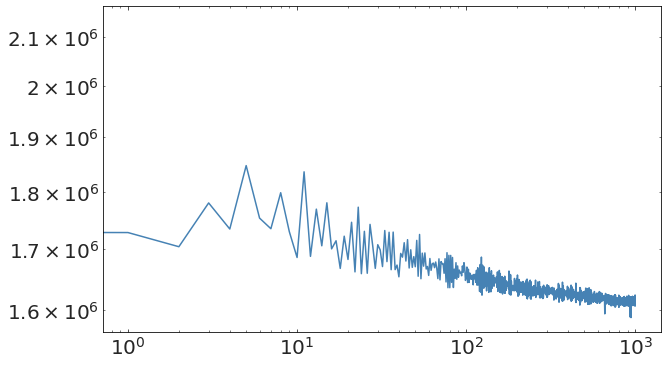

In [32]:
plt.plot(np.array(history.history['loss']))
plt.yscale('log')
plt.xscale('log')


## Predict

In [33]:
output = model.predict(X_te)
output

array([[  0.       ,   0.       ,  58.97191  , ..., 369.19263  ,
          0.       , 140.68463  ],
       [  0.       ,   0.       ,  16.433458 , ...,   0.       ,
          0.       ,   2.2047942],
       [  0.       ,   0.       ,  16.776878 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,  30.01883  , ...,  84.64785  ,
          0.       ,  20.211641 ],
       [  0.       ,   0.       ,  62.220062 , ...,  30.219006 ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  13.878897 , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)